# Problem set 2 (40 + 36 + 35 = 111 pts)

In this problem set we also present some bonus problems that will be considered as in Problem Set 1.

## Problem 1. Segmentation. (40 pts)
In this task, you will need to solve the problem of semantic segmentation of the attributes of a person's face. You will work with [CelebAMask-HQ](https://github.com/switchablenorms/CelebAMask-HQ) dataset. You are free to solve and implement required steps on your own. However, there are several constraints and advices:
- To speed up and simplify experiments, you can transform images to 512x512 resolution and use this [train-test split](https://drive.google.com/file/d/1vO4mJ08FMdcom2-sNs4WHxPztIRYrFYI/view?usp=share_link), that has smaller number of images.
- (20 pts) Implement needed train-test pipeline (dataset, model, train and test loops), train and test the model. 
  - (10 pts) Bonus: your own model, not taken from libraries and not a Unet.
- (5 pts) Report IoU and Dice-scores of each class on the test set.
- (5 pts) Try to add augmentations (helpful [link1](https://albumentations.ai/) and [link2](https://kornia.github.io/)).
- (2 pts) Plot 4-6 examples of obtained results on the test set (show the best and the worst according to the loss/metrics).
- (3 pts) Explain why you solved the problem this way and not otherwise, provide description of experiments and their results. Analyze your metrics, are they suitable?
- (5 pts) Make additional function for inference that receives path to the image. Test your model on several photos not from the dataset (pick your own photo or any other from internet). Does your model work well on the new data?
- Do not use already pretrained on CelebAMask-HQ models.
- **Bonus**: 
  - **+10 points** for top-1 result
  - **+8 points** for 2-3 places
  - **+5 points** for 4-8 places 
according to reported mean Dice score on the provided test split.

In [ ]:
# !unzip dataset_cut.zip 

In [ ]:
# %pip install albumentations
# %pip install segmentation_models_pytorch
# %pip install typing-extensions
# %pip -q install --upgrade torchmetrics
# %pip -q install --upgrade numpy
# %pip -q install --upgrade albumentations
# %pip -q install --upgrade scikit-image
# %pip -q install --upgrade typing-extensions
# %pip -q install --upgrade pandas
# %pip -q install --upgrade numpy
# %pip -q install --upgrade scikit-learn

In [1]:
import os
import torch
from torch import nn
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
import pandas as pd 
from torch.utils.data import Dataset, random_split, DataLoader
import albumentations as alb
from albumentations.pytorch import ToTensorV2
from torchvision import transforms, models
import torchvision
from sklearn.model_selection import train_test_split
import segmentation_models_pytorch as seg_models
from PIL import Image

As we need to merge masks for each image,I considered 2 possible options of working with dataset:
- Primary to creating of dataloaders and training of the model preprocess the data and merge masks in advance,store them in separate directories
- Implement merging in dataset class, while implemeting getitem function.

Using 2nd option will increase time of training the model due to more operations, related to data, while first option will allow to run the preprocessing just 1 time. <br>
Therefore, I will use the first option

In [2]:
face_data = './dataset_cut/im'
mask_path = './dataset_cut/mask'
atts = ['skin', 'l_brow', 'r_brow', 'l_eye', 'r_eye', 'eye_g', 'l_ear', 'r_ear', 'ear_r',
                     'nose', 'mouth', 'u_lip', 'l_lip', 'neck', 'neck_l', 'cloth', 'hair', 'hat']

In [241]:
# Uncomment for first data processing

# face_data = './CelebAMask-HQ/CelebA-HQ-img/'
# face_att_masks = './CelebAMask-HQ/CelebAMask-HQ-mask-anno/'
# mask_path = './CelebAMask-HQ/full_masks/'

# if not os.path.exists(mask_path):
#     os.makedirs(mask_path)

# atts = ['skin', 'l_brow', 'r_brow', 'l_eye', 'r_eye', 'eye_g', 'l_ear', 'r_ear', 'ear_r',
#                     'nose', 'mouth', 'u_lip', 'l_lip', 'neck', 'neck_l', 'cloth', 'hair', 'hat']
# for i in range(15):
    
#     for j in range(i*2000,(i+1)*2000):

#         mask = np.zeros((512, 512))

#         for l, att in enumerate(atts, 1):
            
#             file_name = ''.join([str(j).rjust(5, '0'), '_', att, '.png'])
#             path = os.path.join(face_att_masks, str(i), file_name)

#             if os.path.exists(path):
#                 sep_mask = np.array(Image.open(path).convert('P'))
#                 mask[sep_mask == 225] = l
                
#         cv2.imwrite(f'{mask_path}/{j}.png', mask)

In [32]:
# Function for drawing images and masks
def draw_mask_image(image,ground_truth_mask=None,res_mask=None):
    titles = ['Image','Ground truth mask','output']
    for_plot = [image,ground_truth_mask,res_mask]
    fig = plt.figure()

    if  (res_mask is None) and (ground_truth_mask is None):
        plt.imshow(for_plot[0])
        plt.axis('off')
        plt.title(titles[0])
    elif res_mask is None:
        cols = 2 
        for i in range(cols):
            plt.subplot(1,cols,i+1)
            plt.axis('off')
            plt.imshow(for_plot[i])
            plt.title(titles[i])
    elif ground_truth_mask is None:
        plt.subplot(1,2,1)
        plt.axis('off')
        plt.imshow(for_plot[0])
        plt.title(titles[0])

        plt.subplot(1,2,2)
        plt.axis('off')
        plt.imshow(for_plot[2])
        plt.title(titles[2])
    else:
        cols = 3
        for i in range(cols):
            plt.subplot(1,cols,i+1)
            plt.axis('off')
            plt.imshow(for_plot[i])
            plt.title(titles[i])
    plt.show()

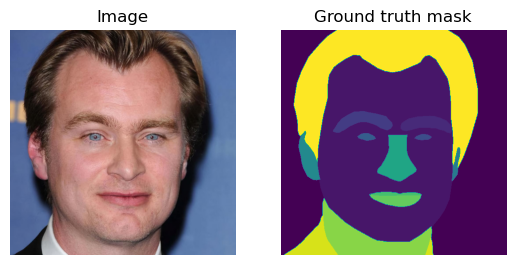

In [33]:
# mask = np.array(Image.open('./CelebAMask-HQ/full_masks/29999.png'))
# im = np.array(Image.open('./CelebAMask-HQ/CelebA-HQ-img/29999.jpg',))

im = np.array(Image.open(os.path.join(face_data,'10040.jpg')))
mask = np.array(Image.open(os.path.join(mask_path,'10040.png')))

draw_mask_image(im,mask)
plt.show()

In [5]:
pd_dataset_cut = pd.read_csv('./dataset_cut/celeb_train_test_split.csv')
test_ds = pd_dataset_cut[pd_dataset_cut['is_train'] == False]

not_test = pd_dataset_cut[pd_dataset_cut['is_train'] == True]
train_ds, val_ds = train_test_split(not_test,test_size = 0.2)

In [6]:
# Creating cut dataset for possible work in collab/datasphere
# import shutil
# src_im = './CelebAMask-HQ/CelebA-HQ-img/'
# src_mask = './CelebAMask-HQ/full_masks/'
# dst_im = './dataset_cut/im'
# dst_mask = './dataset_cut/mask'
# if not os.path.exists(dst_im):
#     os.makedirs(dst_im)
# if not os.path.exists(dst_mask):
#     os.makedirs(dst_mask)

# for name in pd_dataset_cut.name:
#     shutil.copy(os.path.join(src_im,name),os.path.join(dst_im,name))
#     shutil.copy(os.path.join(src_mask,name)[:-3] + 'png',os.path.join(dst_mask,name)[:-3] + 'png')

In [7]:
# Creating custom dataset

class Face_Dataset(Dataset):
    def __init__(self,pd_dataset,img_dir_path,mask_dir_path,transform=None) -> None:
        super().__init__()
        self.pd_dataset = pd_dataset
        self.img_dir_path = img_dir_path
        self.mask_dir_path = mask_dir_path
        self.transform = transform
        
    def __len__(self):
        return self.pd_dataset.shape[0]

    def __getitem__(self,idx):
        img_name = self.pd_dataset.iloc[idx]['name']
        image = np.array(Image.open(os.path.join(self.img_dir_path,img_name)))
        mask = np.array(Image.open(os.path.join(self.mask_dir_path,img_name[:-3] + 'png')))
        if self.transform is not None:
            res = self.transform(image=image,mask=mask)
            image = res['image']
            mask = res['mask']

        return image,mask.type(torch.LongTensor)


In [8]:
train_transform = alb.Compose(
    [
        alb.Normalize(mean=(0.485, 0.456, 0.406),std=(0.229, 0.224, 0.225)),
        alb.Resize(512,512),
        alb.ShiftScaleRotate(rotate_limit=30),
        alb.RandomCrop(height=384,width=384),
        ToTensorV2()
    ]
)

test_transform = alb.Compose(
    [
        alb.Normalize(mean=(0.485, 0.456, 0.406),std=(0.229, 0.224, 0.225)),
        alb.Resize(512,512),
        ToTensorV2()
    ]
)
train_dataset = Face_Dataset(train_ds,face_data,mask_path,train_transform)
val_dataset = Face_Dataset(val_ds,face_data,mask_path,test_transform)
test_dataset = Face_Dataset(test_ds,face_data,mask_path,test_transform)

In [9]:
# IoU and Dice metrics
@torch.no_grad()
def IoU(output_mask,gt_mask,num_classes=19):
    output_mask = output_mask.argmax(dim=1).cpu()
    gt_mask = gt_mask.cpu()

    iou_per_class = []
    for i in range(num_classes):
        if (gt_mask == i).sum().item() == 0:
            iou_per_class.append(np.nan)
        else:
            intersect = torch.logical_and(gt_mask == i,output_mask==i).sum().item()
            union = torch.logical_or(gt_mask == i,output_mask==i).sum().item()
            iou_per_class.append(intersect/union)
    return np.array(iou_per_class)
    
@torch.no_grad()
def Dice(output_mask,gt_mask,num_classes=19):
    output_mask = output_mask.argmax(dim=1).cpu()
    gt_mask = gt_mask.cpu()

    dice_per_class = []
    for i in range(num_classes):
        if (gt_mask == i).sum().item() == 0:
            dice_per_class.append(np.nan)
        else:
            intersect = torch.logical_and(gt_mask == i,output_mask==i).sum().item()
            union = torch.logical_or(gt_mask == i,output_mask==i).sum().item()
            dice_per_class.append(2 * intersect / (union + intersect))
    return np.array(dice_per_class)

In [10]:
def train(model,train_dataloader,criterion,optimizer,device,scheduler=None):
    
    avg_epoch_loss = []
    avg_dice_score = np.empty((1,19))
    avg_dice_score[:] = np.nan
    avg_iou_score = np.empty((1,19))
    avg_iou_score[:] = np.nan

    model.train()
    model.to(device)

    stream = tqdm(train_dataloader)

    for i, (images,masks) in enumerate(stream,start=1):
        images = images.to(device)
        masks = masks.to(device)
        
        out = model(images)

        loss = criterion(out,masks)


        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        

        avg_epoch_loss.append(loss.item())
        avg_dice_score = np.vstack([avg_dice_score, Dice(out,masks)])
        avg_iou_score = np.vstack([avg_iou_score, IoU(out,masks)])

        stream.set_description(
            f'Batch: {i} of {len(train_dataloader)}; Loss on batch: {loss.item()};\
mIoU: {np.nanmean(IoU(out,masks))}; Dice over classes: {np.nanmean(Dice(out,masks))}'
        )

    if scheduler is not None:
            scheduler.step()

    return np.mean(avg_epoch_loss), np.nanmean(avg_dice_score,axis=0), np.nanmean(avg_iou_score,axis=0)

@torch.no_grad()
def val(model,dataloader,criterion,device):
    
    model.eval()
    model.to(device)

    avg_test_loss = []
    avg_dice_score = np.empty((1,19))
    avg_dice_score[:] = np.nan
    avg_iou_score = np.empty((1,19))
    avg_iou_score[:] = np.nan

    stream = tqdm(dataloader)
    
    for i, (images,masks) in enumerate(stream,start=1):
        images = images.to(device)
        masks = masks.to(device)
        
        out = model(images)

        loss = criterion(out,masks)

        avg_test_loss.append(loss.item())

        avg_dice_score = np.vstack([avg_dice_score, Dice(out,masks)])
        avg_iou_score = np.vstack([avg_iou_score, IoU(out,masks)])

        stream.set_description(
            f'Batch: {i} of {len(dataloader)}; Loss on batch: {loss.item()};\
mIoU: {np.nanmean(IoU(out,masks))}; Dice over classes: {np.nanmean(Dice(out,masks))}'
        )
        
    return np.mean(avg_test_loss), np.nanmean(avg_dice_score,axis=0), np.nanmean(avg_iou_score,axis=0)


def fit(model,train_dataset,val_dataset,params):
    train_dataloader = DataLoader(
        train_dataset,batch_size=params['batch_size'],
        shuffle=True,
        num_workers=params['num_workers']
    )
    val_dataloader = DataLoader(
        val_dataset,batch_size=params['batch_size'],
        shuffle=False,
        num_workers=params['num_workers']
    )
    criterion = nn.CrossEntropyLoss()
    opt = torch.optim.Adam(model.parameters(),params['lr'],weight_decay=params['weight_decay'])

    # scheduler = torch.optim.lr_scheduler.

    stream = tqdm(range(1,params['num_epochs']+1))

    for epoch in stream:
        avg_train_loss,avg_train_dice, avg_train_iou = train(model,train_dataloader,criterion,opt,params['device'])
        avg_val_loss,avg_val_dice, avg_val_iou = val(model,val_dataloader,criterion,params['device'])
        PATH = f'./epoch_{epoch}.pt'
        torch.save({
            'model_state':model.state_dict(),
            'params': params
        },PATH)
        print(
            f'Epoch: {epoch} of {params["num_epochs"]}; Train Loss: {avg_train_loss}; Val Loss: {avg_val_loss};\n\
Avg Train Dice  : {np.nanmean(avg_train_dice)}; Avg Train IoU : {np.nanmean(avg_train_iou)}\n\
Avg Val Dice : {np.nanmean(avg_val_dice)}; Avg Val IoU : {np.nanmean(avg_val_iou)}'
        )



In [26]:
@torch.no_grad()
def predict(model,test_dataset,params,criterion):
    
    scores_on_pred ={
        'loss': [],
        'avg_iou' : [],
        'avg_dice': [],
    }

    avg_dice_score = np.empty((1,19))
    avg_dice_score[:] = np.nan
    avg_iou_score = np.empty((1,19))
    avg_iou_score[:] = np.nan
    
    predictions = []

    test_dataloader = DataLoader(
        test_dataset,batch_size=1,
        shuffle=False,
        num_workers=params['num_workers']
    )

    model.eval()
    model.to(params['device'])

    stream = tqdm(test_dataloader)
    
    for images,masks in stream:

        images = images.to(params['device'])
        masks = masks.to(params['device'])
        
        out = model(images)
        loss = criterion(out,masks)
        scores_on_pred['loss'].append(loss.item())
        avg_dice_score = np.vstack([avg_dice_score, Dice(out,masks)])
        avg_iou_score = np.vstack([avg_iou_score, IoU(out,masks)])
        
        dct = dict({
            'image': images.squeeze().permute(1,2,0).cpu().numpy(),
            'gt_mask': masks.squeeze().cpu().numpy(),
            'out_mask': torch.argmax(out,dim=1).squeeze().cpu().numpy()
        })

        predictions.append(dct)
    scores_on_pred['dice_per_class'] = avg_dice_score
    scores_on_pred['iou_per_class'] = avg_iou_score
    return scores_on_pred,predictions

In [251]:
#!g1.1
model = seg_models.UnetPlusPlus('mobilenet_v2',decoder_attention_type='scse',classes=19)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /tmp/xdg_cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


In [252]:
#!g1.1
params = {
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'num_workers': 0,
    'num_epochs': 30,
    'batch_size': 8,
    'lr': 1e-3,
    'weight_decay': 0.0001
}

In [253]:
#!g1.1
fit(model,train_dataset,val_dataset,params)


Epoch: 1 of 30; Train Loss: 0.5700798279047012; Val Loss: 0.35024402338139554;
Avg Train Dice  : 0.3334555239962289; Avg Train IoU : 0.27719530080863125
Avg Val Dice : 0.5572803622458538; Avg Val IoU : 0.4672998572224106



Epoch: 2 of 30; Train Loss: 0.32814513103167214; Val Loss: 0.3027918013803502;
Avg Train Dice  : 0.6275456132643326; Avg Train IoU : 0.5301095330970158
Avg Val Dice : 0.710814520745655; Avg Val IoU : 0.615689951927757



Epoch: 3 of 30; Train Loss: 0.28126288000742594; Val Loss: 0.304278590419191;
Avg Train Dice  : 0.7084226430750604; Avg Train IoU : 0.613205879305058
Avg Val Dice : 0.6828873591119702; Avg Val IoU : 0.579549984438005



Epoch: 4 of 30; Train Loss: 0.2678149141470591; Val Loss: 0.25405652678393303;
Avg Train Dice  : 0.7184530236213611; Avg Train IoU : 0.6263112614017202
Avg Val Dice : 0.7430731582482993; Avg Val IoU : 0.6537741017746725



Epoch: 5 of 30; Train Loss: 0.24736370571454366; Val Loss: 0.2952466163229435;
Avg Train Dice  : 0.7294806749910784; Avg Train IoU : 0.6391911986852584
Avg Val Dice : 0.7270228069640012; Avg Val IoU : 0.6363718266617208



Epoch: 6 of 30; Train Loss: 0.247760404586792; Val Loss: 0.2656783550343615;
Avg Train Dice  : 0.7298941639816118; Avg Train IoU : 0.6406686327311426
Avg Val Dice : 0.7382239093098866; Avg Val IoU : 0.650143320535751



Epoch: 7 of 30; Train Loss: 0.24593247707684834; Val Loss: 0.3335959497601428;
Avg Train Dice  : 0.7357360236489631; Avg Train IoU : 0.6477761047871136
Avg Val Dice : 0.7393116027313787; Avg Val IoU : 0.6478472279764832



Epoch: 8 of 30; Train Loss: 0.23842955299218496; Val Loss: 0.23068484727372515;
Avg Train Dice  : 0.7385537780482623; Avg Train IoU : 0.6506937806221442
Avg Val Dice : 0.7562042006920509; Avg Val IoU : 0.6710006421373796



Epoch: 9 of 30; Train Loss: 0.227514315366745; Val Loss: 0.26760200220853725;
Avg Train Dice  : 0.7412339631343673; Avg Train IoU : 0.6547932237250942
Avg Val Dice : 0.7441779746691575; Avg Val IoU : 0.6569816108811398



Epoch: 10 of 30; Train Loss: 0.2278422935406367; Val Loss: 0.2482887715735334;
Avg Train Dice  : 0.7424538779347306; Avg Train IoU : 0.6559943130050286
Avg Val Dice : 0.7493247334083261; Avg Val IoU : 0.6625567617261844



Epoch: 11 of 30; Train Loss: 0.22569546419382094; Val Loss: 0.25460228434902554;
Avg Train Dice  : 0.7437831627155571; Avg Train IoU : 0.6563014812157666
Avg Val Dice : 0.7551463033701409; Avg Val IoU : 0.670041189041473



Epoch: 12 of 30; Train Loss: 0.22843840674559276; Val Loss: 0.2524771140293872;
Avg Train Dice  : 0.7443855295413843; Avg Train IoU : 0.656340892698002
Avg Val Dice : 0.7507438077301543; Avg Val IoU : 0.6628481489739015



Epoch: 13 of 30; Train Loss: 0.21963807046413422; Val Loss: 0.24010198008506856;
Avg Train Dice  : 0.7465947983693415; Avg Train IoU : 0.6612562487142235
Avg Val Dice : 0.7449149493841479; Avg Val IoU : 0.6605150422607607



Epoch: 14 of 30; Train Loss: 0.21415318073829015; Val Loss: 0.2520120232663256;
Avg Train Dice  : 0.7546961535924178; Avg Train IoU : 0.6681616309733447
Avg Val Dice : 0.7573557297728051; Avg Val IoU : 0.6674739255872287



Epoch: 15 of 30; Train Loss: 0.22497879989941916; Val Loss: 0.23778191074094873;
Avg Train Dice  : 0.7474569524741799; Avg Train IoU : 0.6603502455376774
Avg Val Dice : 0.7459229832712468; Avg Val IoU : 0.6618346666082217



Epoch: 16 of 30; Train Loss: 0.21902878069877624; Val Loss: 0.24049372780830303;
Avg Train Dice  : 0.753145334589372; Avg Train IoU : 0.6671376161467162
Avg Val Dice : 0.7501679610658524; Avg Val IoU : 0.6628311157163744



Epoch: 17 of 30; Train Loss: 0.21739221199353537; Val Loss: 0.21000743744538186;
Avg Train Dice  : 0.7528253284985356; Avg Train IoU : 0.6661090994718171
Avg Val Dice : 0.7632784670225279; Avg Val IoU : 0.6783899966311411



Epoch: 18 of 30; Train Loss: 0.2036456392010053; Val Loss: 0.22949991200832612;
Avg Train Dice  : 0.7602822277742141; Avg Train IoU : 0.6746249025265214
Avg Val Dice : 0.7718779296564994; Avg Val IoU : 0.6840988619613165



Epoch: 19 of 30; Train Loss: 0.21474600456158321; Val Loss: 0.20745105518305557;
Avg Train Dice  : 0.7552064889844292; Avg Train IoU : 0.6678852459857374
Avg Val Dice : 0.7687273194184198; Avg Val IoU : 0.6863920915534784



Epoch: 20 of 30; Train Loss: 0.21260564623276393; Val Loss: 0.21832393307952172;
Avg Train Dice  : 0.7541993526685199; Avg Train IoU : 0.6673577459265027
Avg Val Dice : 0.7682265565980825; Avg Val IoU : 0.6833207699913226


Not enough units in PROJECT to continue executions. Please contact your PROJECT admin.


KeyboardInterrupt: 

Not enough units in PROJECT to continue executions. Please contact your PROJECT admin.


In [27]:
model = seg_models.UnetPlusPlus('mobilenet_v2',decoder_attention_type='scse',classes=19)
file = open('./problem1_epoch_checkpoints/epoch_20.pt','rb')
state = torch.load(file)
file.close()

model.load_state_dict(state['model_state'])
test_scores,preds  = predict(model,test_dataset,params=state['params'],criterion=nn.CrossEntropyLoss())


  0%|          | 0/1250 [00:00<?, ?it/s]

In [28]:
print(f'Mean loss on test: {np.mean(test_scores["loss"])}')
print(f'Mean IoU on test: {np.nanmean(test_scores["iou_per_class"])}')
print(f'Mean Dice on test: {np.nanmean(test_scores["dice_per_class"])}')


data=np.vstack([np.nanmean(test_scores["iou_per_class"],axis=0),np.nanmean(test_scores["dice_per_class"],axis=0)])

pd.DataFrame(data=data,columns=['back'] + [i for i in atts],index=['Mean IoU per class','Mean Dice per class'])

Mean loss on test: 0.21297432902753352
Mean IoU on test: 0.7677878296901468
Mean Dice on test: 0.8454599115739344


,back,skin,l_brow,r_brow,l_eye,r_eye,eye_g,l_ear,r_ear,ear_r,nose,mouth,u_lip,l_lip,neck,neck_l,cloth,hair,hat
Mean IoU per class,0.867506,0.913822,0.699004,0.713242,0.797823,0.786521,0.718573,0.674869,0.657911,0.150963,0.875574,0.788814,0.754739,0.805464,0.774954,0.0,0.554765,0.861292,0.628564
Mean Dice per class,0.920422,0.954175,0.806891,0.820026,0.879802,0.871094,0.778342,0.765330,0.747622,0.210562,0.932680,0.866870,0.852397,0.885739,0.854473,0.0,0.644272,0.917455,0.734044


In [29]:
dice_sort = np.argsort(np.nanmean(test_scores['dice_per_class'][1:,:],axis=1))
iou_sort = np.argsort(np.nanmean(test_scores['iou_per_class'][1:,:],axis=1))


In [30]:
best3_dice = dice_sort[-3:]
worst3_dice = dice_sort[:3]
best3_iou = iou_sort[-3:]
worst3_iou = iou_sort[:3]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Best 3 according to Dice:


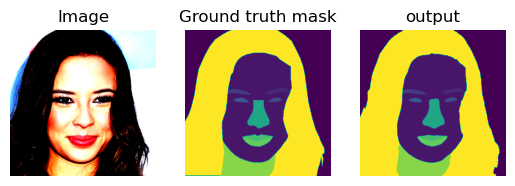

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


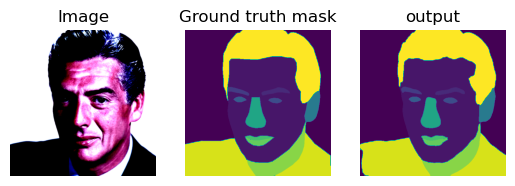

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


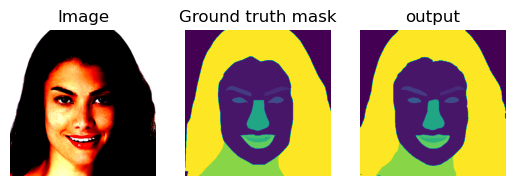

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Worst 3 according to Dice


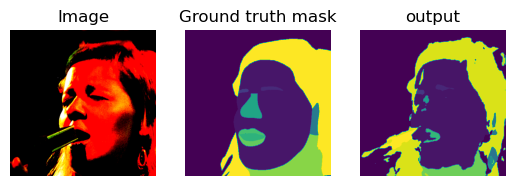

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


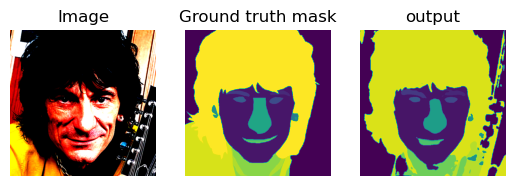

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


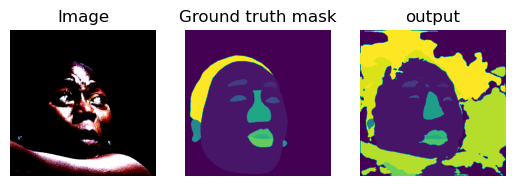

In [34]:
print('Best 3 according to Dice:')
for i in best3_dice.tolist():
    draw_mask_image(preds[i]['image'],preds[i]['gt_mask'],preds[i]['out_mask'])

print('Worst 3 according to Dice')
for i in worst3_dice.tolist():
    draw_mask_image(preds[i]['image'],preds[i]['gt_mask'],preds[i]['out_mask'])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Best 3 according to IoU:


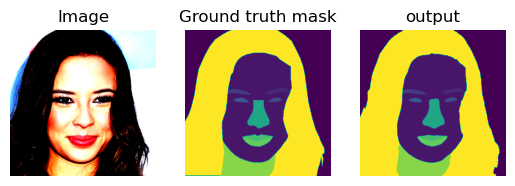

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


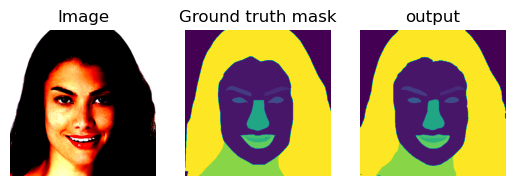

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


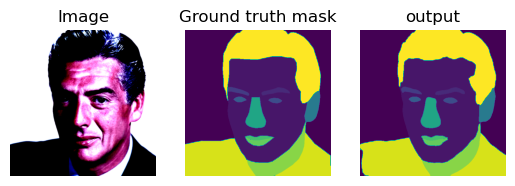

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Worst 3 according to IoU


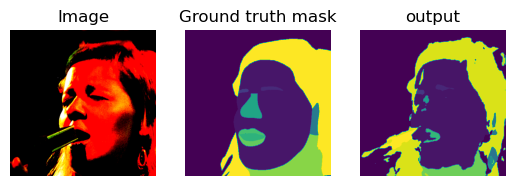

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


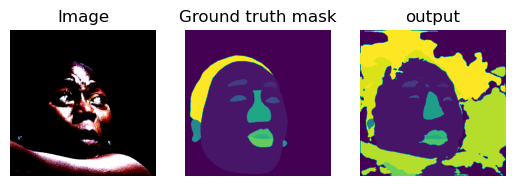

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


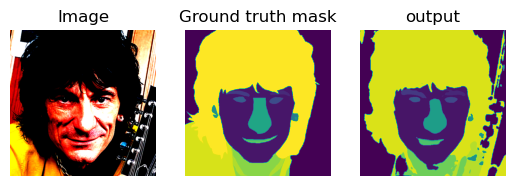

In [35]:
print('Best 3 according to IoU:')
for i in best3_iou:
    draw_mask_image(preds[i]['image'],preds[i]['gt_mask'],preds[i]['out_mask'])

print('Worst 3 according to IoU')
for i in worst3_iou:
    draw_mask_image(preds[i]['image'],preds[i]['gt_mask'],preds[i]['out_mask'])

### About the results of training and experiments
During the creation of the training pipeline, I was trying to come up with the loss function to use during training. Finally I decided to use CrossEntropyLoss, as basically in this task we have classification among 19 classes for each pixel. I was thinking about implementing Dice loss also. I will if I have enough time, but for now I implemented only CrossEntropyLoss. <br>
Speaking about the model: searching already implemeted libs with segmentation models, I found segmentation_models_pytorch lib. I decided to use the Unet++ model from there. The first run of training I used Unet++ model with decoder_attention_type parameter set to None. Also, I ran this model for 5 epochs only to evaluate the metrics on VAL set. Next I set the decoder_attention_type to 'scse' (which is only that is imlemeted in the lib) and made the same run, which provided better results. Therefore I decided to stick to the model with 'scse' decoder_attention_type. Batch size 8, learning rate 1e-3 and weight_decay 1e-4 and 20 epochs were used to train the current model and it achieved following results on test set: <br>

- Mean loss: 0.21297432902753352
- Mean IoU: 0.7677878296901468
- Mean Dice: 0.8454599115739344

Speaking about the IoU and Dice scores on each class, the results of 2 classes caught my attention: `ear_r` and `neck_l` classes scores are very low. The `neck_l` was not classified correctly at all. In first experiment I had this prolem with no classification for class `ear_r` also. It was solved with increasing the number of epochs. I should consider increasing the number of epochs also,maybe it will help. Also there is not so much data with `neck_l` class in it,it might be a problem to.

The mentioned metrics are suitable to evaluate the results of the model, but the loss is not very interpretable. When applying CrossEntropyLoss we basically punish the model for misclassifying a class of a pixel, therefore this metric is suitabale for training. For evaluating, it is more obvious to use Dice and IoU as these are more interpretable.<br>

Possible improvements:
- Add more augmentations, such as ColorJitter for example
- Use Scheduler during training,as after some time of training the Train loss varies not that sufficiently
- Implement Dice loss 
- Consider some more balanced approaches, as there are imbalance in classes 

In [47]:
# Dataset for reading from file

class Face_from_file(Dataset):
    def __init__(self,path_to_imgs,transform=None) -> None:
        super().__init__()
        self.path_to_imgs = path_to_imgs
        self.file_names = os.listdir(path_to_imgs)
        self.transform = transform

    def __len__(self):
        return len(self.file_names) 
    
    def __getitem__(self,idx):
        img_name = self.file_names[idx]
        image = np.array(Image.open(os.path.join(self.path_to_imgs,img_name)))
        if self.transform is not None:
            res = self.transform(image=image)
            image = res['image']
            
        return image

In [48]:
transform = alb.Compose([alb.Normalize(mean=(0.485, 0.456, 0.406),std=(0.229, 0.224, 0.225)),alb.Resize(512,512),ToTensorV2()])

In [49]:
custom_photos_path = './custom/'
custom_dataset = Face_from_file(custom_photos_path,transform=transform)
custom_loader = DataLoader(custom_dataset,batch_size=1)

In [50]:
model = seg_models.UnetPlusPlus('mobilenet_v2',decoder_attention_type='scse',classes=19)
file = open('./problem1_epoch_checkpoints/epoch_20.pt','rb')
state = torch.load(file)
file.close()

model.load_state_dict(state['model_state'])

<All keys matched successfully>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


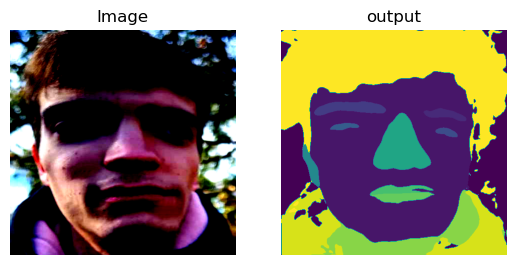

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


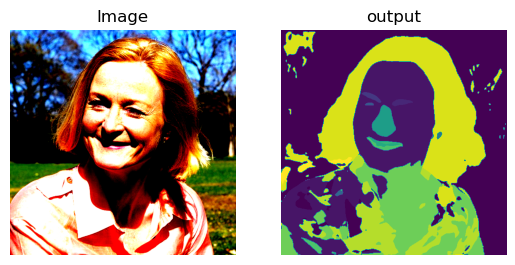

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


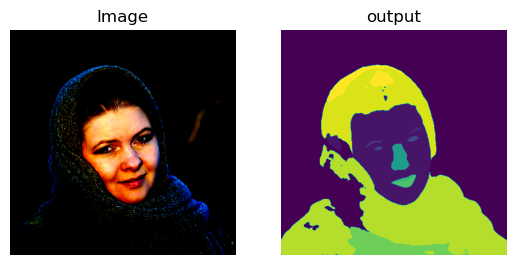

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


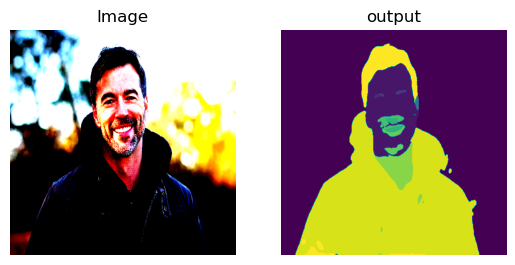

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


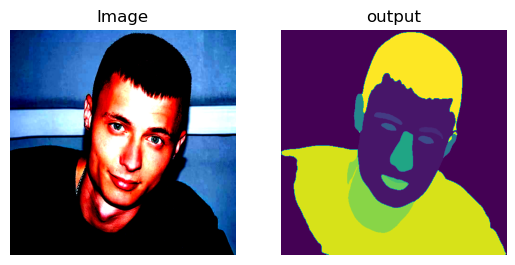

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


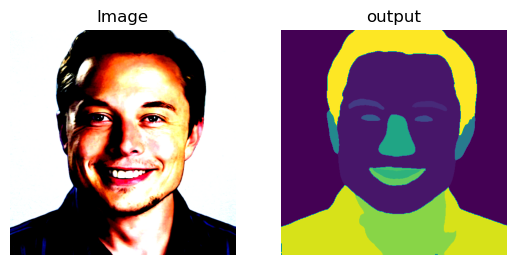

In [56]:
model = model.to('cuda')
model.eval()
for image in custom_loader:
    image = image.to('cuda')

    out = model(image).argmax(dim=1).squeeze().cpu().numpy()
    draw_mask_image(image.squeeze().permute(1,2,0).cpu().numpy(),res_mask=out)
    


### About the results on the custom photos
For the custom photos it can be easily seen that model works good for images, that are close to the ones, that were in training set (images 5 and 6) and the mask looks adequate (but maybe Elon Mask was in the training set, that is why it's not a good idea to judge the quality of model,based on this particular image). Even for very distorted image of face (1st image) the model captures main features of the face. But still there are artifacts. <br>
It may be concluded that model captures main face features on custom photos, but has some problems when working with images, that are very different to the ones in the train set.

## Problem 2. Deep image prior (36 pts)

In the deep prior framework, we aim to learn a prior distribution over the parameters $\theta$ of a generative model such that, given some observation $\hat{y}$, we can sample a plausible output $y$ from the learned prior distribution. The goal is to learn a posterior distribution $p(z,\theta|\hat{y})$ over the latent variable $z$ and the parameters $\theta$ such that, given some observation $\hat{y}$ (e.g., an image of a face), we can sample a plausible latent variable $z$ and generate a corresponding output image $y= f_\theta(z)$ that is similar to the observation. The conditional distribution of $y$ given $\hat{y}$ can be written as an integral over $z$ and $\theta$:

$$p(y|\hat{y}) = \int p(y|z,\theta,\hat{y})p(z,\theta|\hat{y})dzd\theta$$

Unfortunately, in practice, it is difficult to compute this integral exactly, since we don't know the conditional distribution $p(y|z,\theta,\hat{y})$ and the posterior distribution $p(z,\theta|\hat{y})$. Instead, we can use an optimization approach to learn the prior distribution $p(z,\theta)$ and the network $f_\theta(z)$ that best approximate the true conditional distribution.

Specifically, we first assume that the latent variable $z$ is independent of the observation $\hat{y}$, i.e., $p(z,\theta|\hat{y}) = p(\theta|\hat{y})p(z)$. This allows us to rewrite the conditional distribution of $y$ as:

$$p(y|\hat{y}) = \int p(y|z,\theta,\hat{y})p(\theta|\hat{y})p(z)dzd\theta$$

Next, we use an optimization approach to learn the parameters $\theta$ of the network to minimize the expected distance between the generated output $y=f_\theta(z)$ and the observation $\hat{y}$:

$$\min_\theta E(f_\theta(z),\hat{y})$$

To perform this optimization, we can apply a stochastic gradient descent approach where we sample random values of $z$ from the prior distribution $p(z)$ and compute the gradients of the loss function with respect to $\theta$ using backpropagation. This way, we can iteratively update the parameters of the network to improve its ability to generate realistic outputs given the observed data.

This approach is used to perform denoising, inpainting and super resolution. The basic architecture for the task is UNet, which we will use in our experiments.

## Implementation

In [ ]:
import torch
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import torchvision
from torchvision import transforms
import gdown
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from torchmetrics import TotalVariation as TV

In [ ]:
class Encoder_Block(torch.nn.Module):
    def __init__(self,inp_channels,out_channels):
        super().__init__()
        self.model = torch.nn.Sequential(
            torch.nn.Conv2d(inp_channels,out_channels,kernel_size=3,padding=1),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.Conv2d(out_channels,out_channels,kernel_size=3,padding=1),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
        )
        self.downsample = torch.nn.MaxPool2d(2)
    def forward(self,x):
        int_out = self.model(x)
        return self.downsample(int_out), int_out

class Decoder_Block(torch.nn.Module):
    def __init__(self,inp_channels,out_channels):
        super().__init__()
        self.upsample = torch.nn.ConvTranspose2d(inp_channels,out_channels,kernel_size=2,stride=2)
        self.model = torch.nn.Sequential(
            torch.nn.Conv2d(inp_channels,out_channels,kernel_size=3,padding=1),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.Conv2d(out_channels,out_channels,kernel_size=3,padding=1),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
        )
    def forward(self,x,enc_x):
        x = self.upsample(x)
        x = torch.cat([x,enc_x],dim=1)
        return self.model(x)

In [ ]:
class Unet(torch.nn.Module):
    def __init__(self,inc,outc,hidden_size=16):
        super().__init__()
        self.Encoder = torch.nn.ModuleList([
            Encoder_Block(inc,hidden_size),
            Encoder_Block(hidden_size,hidden_size*2),
            Encoder_Block(hidden_size*2,hidden_size*4),
            Encoder_Block(hidden_size*4,hidden_size*8),
        ])
        self.bottleneck = torch.nn.Sequential(
            torch.nn.Conv2d(hidden_size*8,hidden_size*16,kernel_size=1),
            torch.nn.BatchNorm2d(hidden_size*16),
            torch.nn.ReLU(),
            torch.nn.Conv2d(hidden_size*16,hidden_size*16,kernel_size=1),
            torch.nn.BatchNorm2d(hidden_size*16),
            torch.nn.ReLU()
        )
        self.Decoder = torch.nn.ModuleList([
            Decoder_Block(hidden_size*16,hidden_size*8),
            Decoder_Block(hidden_size*8,hidden_size*4),
            Decoder_Block(hidden_size*4,hidden_size*2),
            Decoder_Block(hidden_size*2,hidden_size*1),
        ])
        self.last_layer = torch.nn.Sequential(
            torch.nn.Conv2d(hidden_size,outc,kernel_size=3,padding="same"),
            torch.nn.Sigmoid()
        )
    def forward(self,x):
        enc_xs = []
        for module in self.Encoder:
            x, enc_x= module(x)
            enc_xs.append(enc_x)

        enc_xs = enc_xs[::-1]
        x = self.bottleneck(x)

        for i,module in enumerate(self.Decoder):
            x = module(x,enc_xs[i])
        return self.last_layer(x)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
sharing_link = "https://drive.google.com/file/d/1QMZ9_XdFRfj-arUvW_hlG5Mw8vjzTLsU/view?usp=share_link"
gdown.download(url=sharing_link, output="./data.zip", quiet=False, fuzzy=True)
!unzip ./data.zip

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

In [ ]:
img = transform(Image.open("./data/denoising/F16_GT.png"))[None].to(device)

## Your work starts here

In [ ]:
noise_strength = 0.1
corrupted_img = (img + torch.randn_like(img)*noise_strength).clamp(0,1)

In [ ]:
transforms.ToPILImage()(torchvision.utils.make_grid(torch.cat([corrupted_img,img],dim=0),nrow=2,normalize=True))

## Optimization (6 pts)

Task: Implement an optimization function that takes a model, input image, corrupted image, original image, and the number of iterations as arguments.

Steps:

1. Initialize an optimizer (Adam optimizer with learning rate $10^{-4}$).
2. Write a cycle for optimization using the specified loss function (criterion).
3. In each step of the cycle, add a certain amount of noise (reg_noise=0.01) to the input $z$ to ensure computational stability.

**We have provided baseline values for hyperparameters in this and future tasks, but feel free to make adjustments if needed.**

In [ ]:
def optimization(model,z,corrupted_img,orig_img,iters,criterion=torch.nn.MSELoss(),reg_noise=0.01):
    # your code is here

### Run the optimization (6 pts):

1. Start by initializing the UNet model with 32 input channels, 3 output channels, and a hidden size of 16.
2. Create a model input of size (1, 32, img.size(2), img.size(3)) by sampling from a normal distribution with a mean of 0 and standard deviation of 0.1.
3. Train the model for 3000 iterations.
4. Plot the training convergence with the loss computed for both generated and corrupted images.
5. Plot the training convergence with the loss computed for both generated and original images.
6. Visualize the results, including the original image, the corrupted image, and the restored image.
7. Explain obtained results (**Hint: look closely at the plot from step 5**)

In [ ]:
# your code is here

## Early stopping (3 pts)

One solution to prevent the recurrence of past issues is by terminating the training process at an optimal point. However, determining the ideal number of iterations can be a challenging task. Therefore, your objective is to:

1. Find out appropriate number of iterations (the best reconstruction of original image)
2. Suggest stopping criteria for the denoising task in real case (when you do not know ground truth) (**Hint: use Total Variation metric to measure the amount of noise in the image**)
3. Compare the result of your strategy with found number of iterations in the first step

In [ ]:
# your code is here, find out appropriate number of iterations

In [ ]:
def optimization_modified(model,z,noised_img,orig_img,iters,criterion=torch.nn.MSELoss()):
    #duplicate your previous code and stop optimization according to stopping criteria

## Stochastic gradient Langevin dynamics (SGLD) optimization 

Another way to solve the problem of increasing the loss function over iterations is to adopt optimization procedure. In the explanations above we have already mentioned that the goal of deep prior is to evaluate the integral:

$$p(y|\hat{y}) = \int p(y|z,\theta,\hat{y})p(\theta|\hat{y})p(z)dzd\theta$$

Instead of directly solving the integral, we can use the Markov chain Monte Carlo (MCMC) method to estimate the posterior. This involves generating a sequence of correlated samples from the target distribution, which can converge to the true posterior during iterations. However, the MCMC approach can be slow and inefficient, and hence, using gradient-based optimization with noise can be a more effective solution. This involves minimizing the objective function and introducing noise to the gradient updates:

$$\theta_{i+1} = \theta_{i} + \mathrm{lr}\cdot\Delta_{i}^{\mathrm{standard}} + s\cdot\mathrm{lr}\cdot\epsilon$$

where $\Delta_{i}^{\mathrm{standard}}$ standard optimization update, $\mathrm{lr}$ - learning rate, $\epsilon \sim N(0,1)$, $s$ - strength of added noise.

More details of how and why it works described in [paper](https://arxiv.org/pdf/1904.07457.pdf)

### Implement SGLD (5 pts)

1. Take the previous implementation of the optimization procedure and adjust it to add noise to the model parameters after each iteration, but **only for convolutional layers**.
2. Set the strength of added noise to 4.
3. Plot the training convergence with the loss computed for generated and corrupted images.
4. Plot the training convergence with the loss computed for generated and original images.
5. Analyze and explain the results in comparison to the Early Stopping approach.
6. Try different values for the strength of added noise $s$ and comment the results.

In [ ]:
def SGLD(model,z,corrupted_img,orig_img,iters,criterion=torch.nn.MSELoss(),reg_noise=0.01):
    # your code is here

In [ ]:
# your code is here

## Inpainting

Deep Image Prior is a versatile tool that can be utilized in solving an important task such as image inpainting. In this task, the challenge lies in the inability to obtain values for the pixels that are damaged and defined by the mask. Thus, during the training process, it is essential to apply the mask to the generated image as these values are unavailable for this particular task. Furthermore, in order to effectively address this issue, you will try a more complex model called AttentionUNet. This model is similar to the UNet model in terms of structure but with the inclusion of attention blocks in the decoder part. 

### Attention block (10 pts)

For AttentionUNet implementation you only need to implement Attention layer. Attention should scale hidden output of encoder block which is also an input for the corresponding decoder block in order to draw more "attention" to particular image parts. Below we have placed the pipeline which you should implement:

**Input:** $skip$ of size [batch,skip_channels,H_skip,W_skip], $x$ of size [batch,x_channels,H_x,W_x]

**Output:** $skip^*$ of size [batch,skip_channels,H_skip,W_skip]

1. Apply 2d convolution with kernel size $2$ to $skip$ to make it of size [batch,skip_channels,H_x,W_x] (recall that 2H_x = H_skip, 2W_x = W_skip)
2. Apply 2d convolution with kernel size $1$ to $x$ to make it of size [batch,skip_channels,H_x,W_x]
3. Sum the outputs of previous two steps and apply ReLU over it.
4. Apply 2d convolution to previous output to reduce channel dimension to 1. So the output should have size equal [batch,1,H_x,W_x]
5. Apply Sigmoid to the previous output to get attention itself
6. Apply attention to the input $skip$ (original block input **NOT** the output of the first step) by simply multipling $skip$ by attention element-wise.

In [ ]:
class Attention(torch.nn.Module):
    def __init__(self,skip_channels, x_channels):
        super().__init__()
        # your code is here
    def forward(self,skip,x):
        # your code is here

In [ ]:
class Decoder_Block_With_Attention(torch.nn.Module):
    def __init__(self,inp_channels,out_channels):
        super().__init__()
        self.upsample = torch.nn.ConvTranspose2d(inp_channels,out_channels,kernel_size=2,stride=2)
        self.model = torch.nn.Sequential(
            torch.nn.Conv2d(inp_channels,out_channels,kernel_size=3,padding=1),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.Conv2d(out_channels,out_channels,kernel_size=3,padding=1),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
        )
        self.attention = Attention(out_channels,inp_channels)
    def forward(self,x,enc_x):
        enc_x = self.attention(enc_x,x)
        x = self.upsample(x)
        x = torch.cat([x,enc_x],dim=1)
        return self.model(x)


class AttentionUnet(torch.nn.Module):
    def __init__(self,inc,outc,hidden_size=16):
        super().__init__()
        self.Encoder = torch.nn.ModuleList([
            Encoder_Block(inc,hidden_size),
            Encoder_Block(hidden_size,hidden_size*2),
            Encoder_Block(hidden_size*2,hidden_size*4),
            Encoder_Block(hidden_size*4,hidden_size*8),
        ])
        self.bottleneck = torch.nn.Sequential(
            torch.nn.Conv2d(hidden_size*8,hidden_size*16,kernel_size=1),
            torch.nn.BatchNorm2d(hidden_size*16),
            torch.nn.ReLU(),
            torch.nn.Conv2d(hidden_size*16,hidden_size*16,kernel_size=1),
            torch.nn.BatchNorm2d(hidden_size*16),
            torch.nn.ReLU()
        )
        self.Decoder = torch.nn.ModuleList([
            Decoder_Block_With_Attention(hidden_size*16,hidden_size*8),
            Decoder_Block_With_Attention(hidden_size*8,hidden_size*4),
            Decoder_Block_With_Attention(hidden_size*4,hidden_size*2),
            Decoder_Block_With_Attention(hidden_size*2,hidden_size*1),
        ])
        self.last_layer = torch.nn.Sequential(
            torch.nn.Conv2d(hidden_size,outc,kernel_size=3,padding="same"),
            torch.nn.Sigmoid()
        )
    def forward(self,x):
        enc_xs = []
        for module in self.Encoder:
            x, enc_x= module(x)
            enc_xs.append(enc_x)

        enc_xs = enc_xs[::-1]
        x = self.bottleneck(x)

        for i,module in enumerate(self.Decoder):
            x = module(x,enc_xs[i])
        return self.last_layer(x)

In [ ]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(256),
    transforms.ToTensor()
])

In [ ]:
img = transform(Image.open("./data/inpainting/library.png"))[None].to(device)
img_mask = transform(Image.open("./data/inpainting/library_mask.png"))[None].to(device)
corrupted_img = img * img_mask

In [ ]:
transforms.ToPILImage()(torchvision.utils.make_grid(torch.cat([corrupted_img,img],dim=0),nrow=2,normalize=True))

### Modify SGLD optimization (6 pts):
1. Take the code for SGLD and update loss calculation by applying mask to generated image (take $s$ = 4, lr = $4 \cdot 10^{-4}$, reg_noise = $0.2$, iters=$2000$)
2. Run the code and evaluate how well model fitted to known pixels and restore the missed one
3. Run the same code with standard UNet model and compare results with AttentionUNet. What conclusion can you make?


**Bonus task (4 pts)** Try to find optimal hyper parameters (strength of added noise $s$, learning rate, reg_noise, number of iterations)

In [ ]:
def optimization_inpainting(model,z,corrupted_img,mask,orig_img,iters,criterion=torch.nn.MSELoss(),reg_noise=0.03):
    #your code is here

In [ ]:
nc = 2
model_without_attention = Unet(nc,3,hidden_size=16).to(device)
z = torch.cat(torch.meshgrid(torch.arange(img.size(2))/img.size(2),torch.arange(img.size(3))/img.size(3))).reshape(1,2,img.size(2),img.size(3)).to(device)

In [ ]:
# your code is here

In [ ]:
nc = 2
model_with_attention = AttentionUnet(nc,3,hidden_size=16).to(device)
z = torch.cat(torch.meshgrid(torch.arange(img.size(2))/img.size(2),torch.arange(img.size(3))/img.size(3))).reshape(1,2,img.size(2),img.size(3)).to(device)

In [ ]:
# your code is here

## Problem 3. Natural language generation (35 pts)

This problem requires uploading two csv files along with the solution notebook. Please compress these three files in zip archive and upload it in Canvas. 

Natural language generation (NLG) is a well-known research problem concerned with generating textual descriptions of structured data, such as tables, as output. Compared to machine translation, where the goal is to completely convert an input sentence into another language, NLG requires overcoming two different challenges: deciding what to say, by selecting a relevant subset of the input data to describe, and deciding how to say it, by generating text that flows and reads naturally. 

In this task you will need to generate table descriptions and titles for the dataset that can be downloaded from the [link](https://box.skoltech.ru/index.php/s/DRfJFNUJMgmLxOU). Your inference pipeline should receive `.csv` and output 2 strings: table description `text` and table title `title`.

As the solution to this task you shoud complete `submission.csv` and `submission_reranking.csv` files as below and report the link on your finetuned checkpoints.

In [ ]:
import pandas as pd

data = pd.read_csv('./train.csv', index_col=0)
data.head(5)

In [ ]:
sample = pd.read_csv('./data/1056174336234335.csv', index_col=0)
sample

In [ ]:
submission = pd.read_csv('./submission.csv', index_col=0)
submission.head(5)

- (**5 pts**) Propose and implement at least 2 variants of the input data preprocessing from tables to string data.
- (**5 pts**) Fine-tune [T5](https://huggingface.co/docs/transformers/model_doc/t5) as a baseline using `t5-base` checkpoint ([paper](https://arxiv.org/pdf/1910.10683.pdf)). In order to handle 2 types of output, test usage of prefixes for T5 model.
- (**5 pts**) Propose and implement at least 2 variants of data augmentation, retune T5 and compare performance.
- (**5 pts**) Add domain adoptation via additional Masked language modeling loss (MLM, [paper, section 3.1, Task #1](https://arxiv.org/pdf/1810.04805.pdf)) loss term for encoder, provide hyperparameter search for the regularization parameter $\lambda$, use BERTScore as objective, compare performance:
$$L(x, y) = -LogLikelihood(x, y) + \lambda L_{MLM}(x_{masked}, x)$$


The following metrics should be reported:
- [SacreBLEU](https://github.com/mjpost/sacrebleu)
- [ROUGEL](https://github.com/google-research/google-research/tree/master/rouge)
- [METEOR](https://www.nltk.org/_modules/nltk/translate/meteor_score.html)
- [BERTScore](https://github.com/Tiiiger/bert_score) using `bert-base-uncased` checkpoint and 9th layer output

Using the best checkpoint from above prepare submission file `submission.csv`, where index is a table caption from the `data` folder, and report the link on your finetuned checkpoint.

In [ ]:
# Your code is here

## Reranking approach (15 pts)

Using maximum likelihood, an ideal model will assign all probability mass to the reference summary. During inference, the model must also generate the output based on possibly erroneous previous steps. This can affect the performance of the model, a phenomenon often called exposure bias. One way to solve this problem is to require our model to be able to accurately predict the ranking order of a set of most likely candidates via an additional contrastive loss term

$$L(x, y) = -LogLikelihood(x, y) + L_{contrastive}(x, y)$$

where

$$
L_{contrastive}(x, y) = \sum_i\sum_{j < i}\max(0, f(s_i(x)) - f(s_j(x)) + \alpha_{ij})
$$

where $\alpha_{ij} = \alpha \cdot (i - j)$ is a margin, $s_i$ and $s_j$ are different candidates (generated by [beam search](https://huggingface.co/blog/how-to-generate)) such that for selected ranking function $r$ $r(s_j, y) > r(s_i, y)$, and 
$f(s)$ is a length-normalised estimated log-probability:

$$
f(s) = \frac{\sum_{t} LogProb(s_t| s_{<t}, x)}{|x|},
$$

where $|x|$ is a lenght of $x$.

Your task is to fine-tune the model with reranking-aware loss using BERTScore as the ranking function $r$, provide hyperparameter search for the margin scaling factor $\alpha$ using BERTScore as objective, report metrics for the best case (SacreBLEU, ROUGEL, METEOR, BERTScore), and prepare the submission file `submission_reranking.csv` and report the link on your finetuned checkpoint.

In [ ]:
# Your code is here